# Further Analysis and Model Tuning

## 1.1 Deeper Analysis of Reviews #V1

### Analyzing Positive Reviews & Negative Reviews #1

In [26]:
import pandas as pd

# Load the classified reviews CSV file
file_path = '5.3_classified_reviews.csv'
df_classified = pd.read_csv(file_path)

# Extract positive reviews classified by VADER
positive_reviews_vader = df_classified[df_classified['Sentiment_VADER'] == 'positive']['Comment']

# Extract positive reviews classified by Transformers
positive_reviews_transformers = df_classified[df_classified['Sentiment_Transformers'] == 'positive']['Comment']

# Display a sample of positive reviews
positive_reviews_vader_sample = positive_reviews_vader.sample(5).tolist()
positive_reviews_transformers_sample = positive_reviews_transformers.sample(5).tolist()

print(positive_reviews_vader_sample)
print(positive_reviews_transformers_sample)

# Extract negative reviews classified by VADER
negative_reviews_vader = df_classified[df_classified['Sentiment_VADER'] == 'negative']['Comment']

# Extract negative reviews classified by Transformers
negative_reviews_transformers = df_classified[df_classified['Sentiment_Transformers'] == 'negative']['Comment']

# Display a sample of negative reviews
negative_reviews_vader_sample = negative_reviews_vader.sample(5).tolist()
negative_reviews_transformers_sample = negative_reviews_transformers.sample(5).tolist()

print(negative_reviews_vader_sample)
print(negative_reviews_transformers_sample)

['soo nice smooth fast light speed', 'good nice', 'good mouse', 'working perfectly', 'couple knock ding box product good']
['product good delivery speed also fast order 127 come 147 although live selangor come johor good seller buy', 'good packaging', 'received 10 day box dent fortunately mouse everything well', 'good quality poor handling parcel', 'got recommended baobao due collab stream pleased quality got 1st logitech equipment buy logitech future p collab baobao tq']
['item received well package bubble wrapped damage delivery expected 2 week received 5 day earlier thankyou lazada logitech worth money buy', 'complaint buy logitech shop there offer next time', 'actually quite hesitate whrn buy mouse cu crazy expensive received tried mouse really give sense worthy buttt dont mouse led light one line think broken shitttto good customer still give 5stats la', 'gud function properly bought bcos razer basilisk x kinda broken', 'courier throw parcel house without informing anything didnt 

### Identifying Common Themes #1
Use NLP techniques to identify common themes in positive and negative reviews.

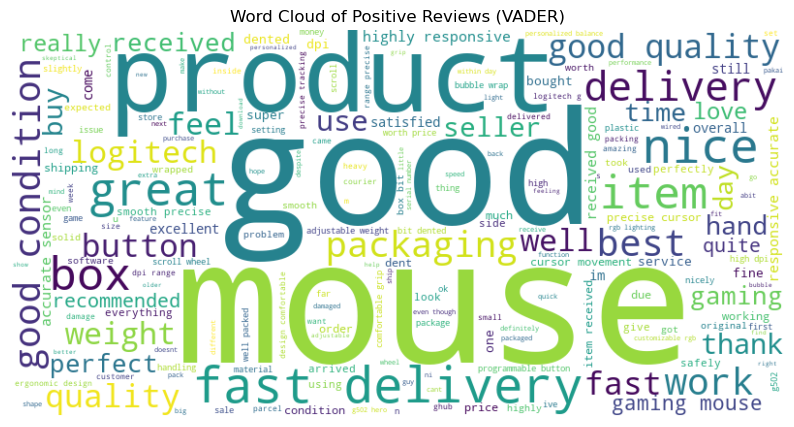

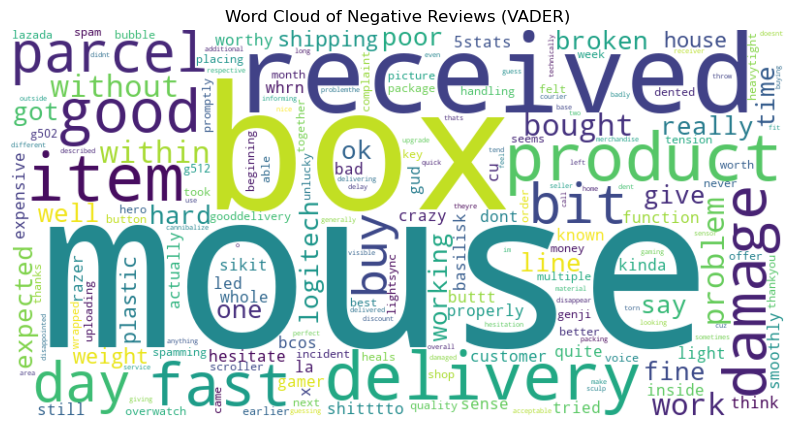

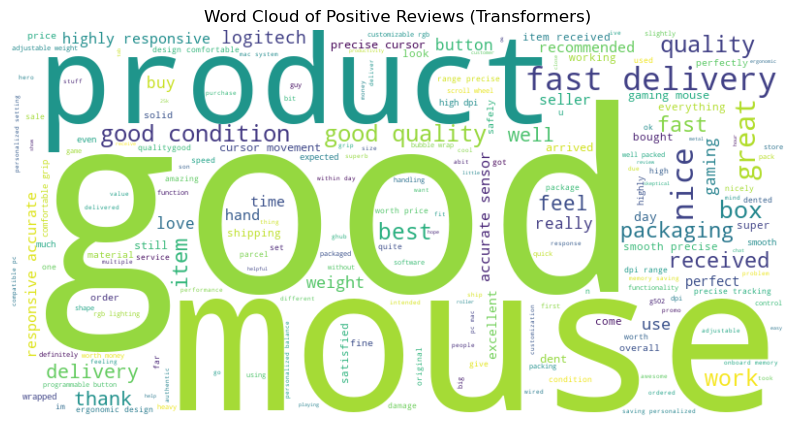

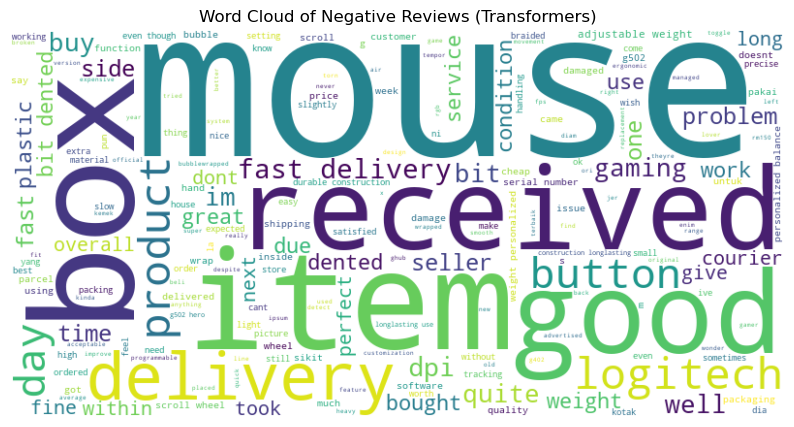

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(reviews, title):
    text = ' '.join(reviews)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for positive and negative reviews
plot_wordcloud(positive_reviews_vader.tolist(), 'Word Cloud of Positive Reviews (VADER)')
plot_wordcloud(negative_reviews_vader.tolist(), 'Word Cloud of Negative Reviews (VADER)')
plot_wordcloud(positive_reviews_transformers.tolist(), 'Word Cloud of Positive Reviews (Transformers)')
plot_wordcloud(negative_reviews_transformers.tolist(), 'Word Cloud of Negative Reviews (Transformers)')

## 2.1 Fine-Tuning Models #V1
### Fine-Tuning VADER Model #1
Adjust the VADER model's parameters to improve its performance.

In [28]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Load the classified reviews CSV file
file_path = '5.3_classified_reviews.csv'
df_classified = pd.read_csv(file_path)

# Create the Sentiment_TextBlob column if it doesn't exist
def get_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

if 'Sentiment_TextBlob' not in df_classified.columns:
    df_classified['Sentiment_TextBlob'] = df_classified['Comment'].apply(get_sentiment_textblob)

# Fine-tuning VADER
sid = SentimentIntensityAnalyzer()
sid.lexicon.update({'great': 3.0, 'excellent': 3.0, 'bad': -3.0, 'terrible': -3.0})

def get_sentiment_vader_tuned(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] > 0.1:
        return 'positive'
    elif scores['compound'] < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply the fine-tuned VADER sentiment analysis
df_classified['Sentiment_VADER_Tuned'] = df_classified['Comment'].apply(get_sentiment_vader_tuned)

# Evaluate the performance of the fine-tuned VADER model
true_labels = df_classified['Sentiment_TextBlob']  # Using TextBlob as the baseline

print("Fine-Tuned VADER Sentiment Analysis Evaluation")
print(classification_report(true_labels, df_classified['Sentiment_VADER_Tuned']))


Fine-Tuned VADER Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.40      0.38      0.39        16
     neutral       0.59      0.85      0.70        52
    positive       0.95      0.89      0.92       333

    accuracy                           0.87       401
   macro avg       0.65      0.70      0.67       401
weighted avg       0.88      0.87      0.87       401



### Fine-Tuning Transformers Model #1
Fine-tune a pre-trained Transformers model using our dataset.

In [29]:
import pandas as pd
import torch
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset

# Load the classified reviews CSV file
file_path = '5.3_classified_reviews.csv'
df_classified = pd.read_csv(file_path)

# Ensure Sentiment_TextBlob column exists
def get_sentiment_textblob(text):
    from textblob import TextBlob
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

if 'Sentiment_TextBlob' not in df_classified.columns:
    df_classified['Sentiment_TextBlob'] = df_classified['Comment'].apply(get_sentiment_textblob)

# Prepare the dataset for fine-tuning
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Encode the dataset
def encode_reviews(reviews, labels):
    encodings = tokenizer(reviews, truncation=True, padding=True, max_length=128)
    encodings['labels'] = labels
    return Dataset.from_dict(encodings)

# Encode the reviews
reviews = df_classified['Comment'].tolist()
labels = df_classified['Sentiment_TextBlob'].apply(lambda x: 0 if x == 'negative' else 1 if x == 'neutral' else 2).tolist()
train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

train_dataset = encode_reviews(train_reviews, train_labels)
val_dataset = encode_reviews(val_reviews, val_labels)

# Fine-tune the Transformers model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Use eval_strategy instead of evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# Evaluate the fine-tuned Transformers model
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = predictions.argmax(axis=1)

print("Fine-Tuned Transformers Sentiment Analysis Evaluation")
print(classification_report(val_labels, predicted_labels, target_names=['negative', 'neutral', 'positive']))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.5564106702804565, 'eval_runtime': 3.2588, 'eval_samples_per_second': 24.856, 'eval_steps_per_second': 1.841, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.5104182362556458, 'eval_runtime': 3.4711, 'eval_samples_per_second': 23.336, 'eval_steps_per_second': 1.729, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.4916916489601135, 'eval_runtime': 3.3196, 'eval_samples_per_second': 24.401, 'eval_steps_per_second': 1.807, 'epoch': 3.0}
{'train_runtime': 158.157, 'train_samples_per_second': 6.07, 'train_steps_per_second': 0.379, 'train_loss': 0.5416817982991536, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Fine-Tuned Transformers Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.00      0.00      0.00         8
    positive       0.83      1.00      0.91        67

    accuracy                           0.83        81
   macro avg       0.28      0.33      0.30        81
weighted avg       0.68      0.83      0.75        81



c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Further Analysis and Advanced Model Tuning

## 1.2 Deeper Analysis of Reviews #V2

### Analyzing Positive Reviews #2

In [30]:
# Extract positive reviews classified by VADER
positive_reviews_vader = df_classified[df_classified['Sentiment_VADER'] == 'positive']['Comment']

# Extract positive reviews classified by Transformers
positive_reviews_transformers = df_classified[df_classified['Sentiment_Transformers'] == 'positive']['Comment']

# Display a sample of positive reviews
positive_reviews_vader_sample = positive_reviews_vader.sample(5).tolist()
positive_reviews_transformers_sample = positive_reviews_transformers.sample(5).tolist()

print(positive_reviews_vader_sample)
print(positive_reviews_transformers_sample)

# Extract negative reviews classified by VADER
negative_reviews_vader = df_classified[df_classified['Sentiment_VADER'] == 'negative']['Comment']

# Extract negative reviews classified by Transformers
negative_reviews_transformers = df_classified[df_classified['Sentiment_Transformers'] == 'negative']['Comment']

# Display a sample of negative reviews
negative_reviews_vader_sample = negative_reviews_vader.sample(5).tolist()
negative_reviews_transformers_sample = negative_reviews_transformers.sample(5).tolist()

print(negative_reviews_vader_sample)
print(negative_reviews_transformers_sample)

['got product safely', 'really solid mouse replaced g402 item arrived relatively fast', 'good super fast delivery 2 day worth try good gaming work use', 'good material good quality fast delivery good function thanks', 'love']
['fast delivery good condition', 'shipping quick product described weight feel nice without additional weight perfect upgrade', '2 working day deliver well packed product good working son like alot tq', 'good', 'mouse good quality look cool shortcoming mouse heavy big']
['complaint buy logitech shop there offer next time', 'received promptly without incident thanks best mouse ever bought work', 'fast delivery damage product well known mouse gamer', 'fast delivery box got damaged bit', 'bought g502 hero g512 lightsync together item came within 5 day placing order multiple button mouse able spam voice line key overwatch never felt better say genji spamming heals']
['bought g502 hero g512 lightsync together item came within 5 day placing order multiple button mouse a

### Identifying Common Themes #2
Use NLP techniques to identify common themes in positive and negative reviews.

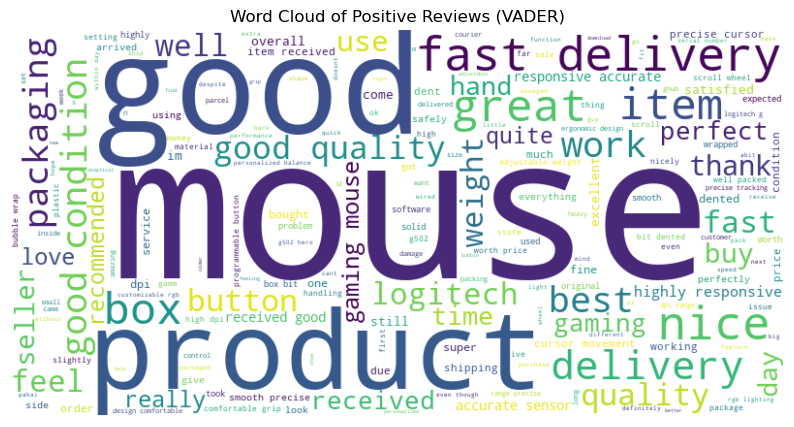

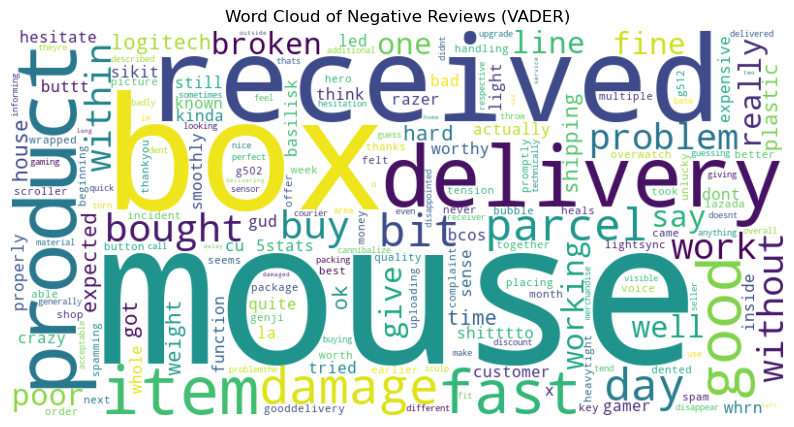

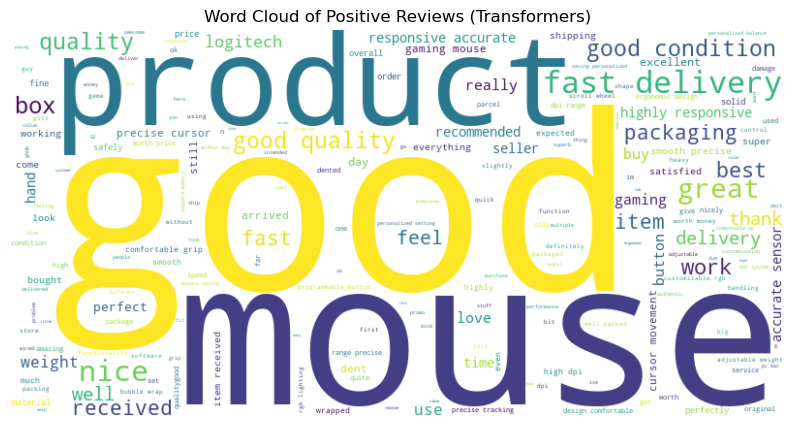

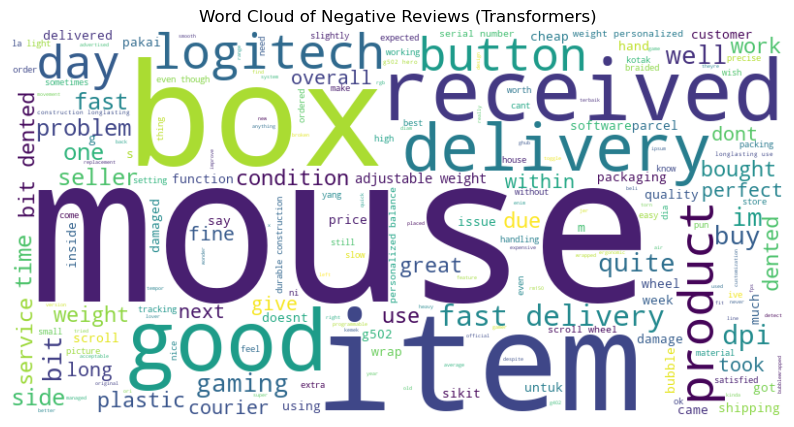

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(reviews, title):
    text = ' '.join(reviews)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for positive and negative reviews
plot_wordcloud(positive_reviews_vader.tolist(), 'Word Cloud of Positive Reviews (VADER)')
plot_wordcloud(negative_reviews_vader.tolist(), 'Word Cloud of Negative Reviews (VADER)')
plot_wordcloud(positive_reviews_transformers.tolist(), 'Word Cloud of Positive Reviews (Transformers)')
plot_wordcloud(negative_reviews_transformers.tolist(), 'Word Cloud of Negative Reviews (Transformers)')

## 2.2 Fine-Tuning the Transformers Model #V2

### Fine-Tuning VADER Model #2
Adjust the VADER model's parameters to improve its performance.

In [32]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the classified reviews CSV file
file_path = '5.3_classified_reviews.csv'
df_classified = pd.read_csv(file_path)

# Create the Sentiment_TextBlob column if it doesn't exist
def get_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

if 'Sentiment_TextBlob' not in df_classified.columns:
    df_classified['Sentiment_TextBlob'] = df_classified['Comment'].apply(get_sentiment_textblob)

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to evaluate VADER model
def evaluate_vader_model(sid, df):
    def get_sentiment_vader(text):
        scores = sid.polarity_scores(text)
        if scores['compound'] > 0.1:
            return 'positive'
        elif scores['compound'] < -0.1:
            return 'negative'
        else:
            return 'neutral'

    # Apply VADER sentiment analysis
    df['Sentiment_VADER'] = df['Comment'].apply(get_sentiment_vader)
    
    # Evaluate the performance of the VADER model
    true_labels = df['Sentiment_TextBlob']
    print("VADER Sentiment Analysis Evaluation")
    print(classification_report(true_labels, df['Sentiment_VADER']))

# Initial evaluation
print("Initial VADER Model Evaluation")
evaluate_vader_model(sid, df_classified)

# Iteratively update the VADER lexicon based on misclassifications
for iteration in range(3):  # Adjust the number of iterations as needed
    print(f"\nIteration {iteration + 1} - Updating Lexicon")
    
    # Identify misclassified samples
    misclassified = df_classified[df_classified['Sentiment_VADER'] != df_classified['Sentiment_TextBlob']]
    
    # Example: Manually review and update the lexicon based on common misclassifications
    # This step should ideally involve domain-specific knowledge and analysis
    # For demonstration, let's assume we manually identified some words to update
    custom_updates = {
        'amazing': 4.0,
        'awesome': 4.0,
        'awful': -4.0,
        'horrible': -4.0,
        'good': 2.0,
        'bad': -2.0,
        # Add more words as identified
    }
    
    # Update VADER lexicon
    sid.lexicon.update(custom_updates)
    
    # Re-evaluate the model after lexicon update
    evaluate_vader_model(sid, df_classified)

Initial VADER Model Evaluation
VADER Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.40      0.38      0.39        16
     neutral       0.59      0.85      0.70        52
    positive       0.95      0.89      0.92       333

    accuracy                           0.87       401
   macro avg       0.65      0.70      0.67       401
weighted avg       0.88      0.87      0.87       401


Iteration 1 - Updating Lexicon
VADER Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.43      0.38      0.40        16
     neutral       0.59      0.85      0.70        52
    positive       0.95      0.89      0.92       333

    accuracy                           0.87       401
   macro avg       0.66      0.71      0.67       401
weighted avg       0.88      0.87      0.87       401


Iteration 2 - Updating Lexicon
VADER Sentiment Analysis Evaluation
              precision    recall  

In [33]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the classified reviews CSV file
file_path = '5.3_classified_reviews.csv'
df_classified = pd.read_csv(file_path)

# Create the Sentiment_TextBlob column if it doesn't exist
def get_sentiment_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

if 'Sentiment_TextBlob' not in df_classified.columns:
    df_classified['Sentiment_TextBlob'] = df_classified['Comment'].apply(get_sentiment_textblob)

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to evaluate VADER model
def evaluate_vader_model(sid, df):
    def get_sentiment_vader(text):
        scores = sid.polarity_scores(text)
        if scores['compound'] > 0.1:
            return 'positive'
        elif scores['compound'] < -0.1:
            return 'negative'
        else:
            return 'neutral'

    # Apply VADER sentiment analysis
    df['Sentiment_VADER'] = df['Comment'].apply(get_sentiment_vader)
    
    # Evaluate the performance of the VADER model
    true_labels = df['Sentiment_TextBlob']
    print("VADER Sentiment Analysis Evaluation")
    print(classification_report(true_labels, df['Sentiment_VADER']))

# Initial evaluation
print("Initial VADER Model Evaluation")
evaluate_vader_model(sid, df_classified)

# Iteratively update the VADER lexicon based on misclassifications
for iteration in range(3):  # Adjust the number of iterations as needed
    print(f"\nIteration {iteration + 1} - Updating Lexicon")
    
    # Identify misclassified samples
    misclassified = df_classified[df_classified['Sentiment_VADER'] != df_classified['Sentiment_TextBlob']]
    
    # Example: Manually review and update the lexicon based on common misclassifications
    # This step should ideally involve domain-specific knowledge and analysis
    # For demonstration, let's assume we manually identified some words to update
    custom_updates = {
        'amazing': 4.0,
        'awesome': 4.0,
        'awful': -4.0,
        'horrible': -4.0,
        'good': 2.0,
        'bad': -2.0,
        'mediocre': -1.5,
        'fantastic': 4.5,
        'terbaik': 3.0,      # Best (Bahasa Melayu)
        'buruk': -3.0,       # Bad (Bahasa Melayu)
        'puas': 2.5,         # Satisfied (Bahasa Melayu)
        'kecewa': -3.0,      # Disappointed (Bahasa Melayu)
        'menakjubkan': 4.0,  # Amazing (Bahasa Melayu)
        'teruk': -3.5        # Terrible (Bahasa Melayu)
    }
    
    
    # Update VADER lexicon
    sid.lexicon.update(custom_updates)
    
    # Re-evaluate the model after lexicon update
    evaluate_vader_model(sid, df_classified)

# Further analyze and refine
misclassified = df_classified[df_classified['Sentiment_VADER'] != df_classified['Sentiment_TextBlob']]
misclassified_sample = misclassified.sample(10)  # Sample 10 misclassified reviews for manual inspection

print(misclassified_sample[['Comment', 'Sentiment_TextBlob', 'Sentiment_VADER']])

# Example: Additional updates based on detailed analysis
additional_updates = {
    'fantastic': 4.0,
    'awful': -4.0,
    'disappointed': -3.0,
    'satisfied': 2.5,
    'terrific': 4.0,
    'poor': -3.0,
    # Add more words as identified
}

# Update VADER lexicon again
sid.lexicon.update(additional_updates)

# Re-evaluate the model after additional updates
evaluate_vader_model(sid, df_classified)

Initial VADER Model Evaluation
VADER Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.40      0.38      0.39        16
     neutral       0.59      0.85      0.70        52
    positive       0.95      0.89      0.92       333

    accuracy                           0.87       401
   macro avg       0.65      0.70      0.67       401
weighted avg       0.88      0.87      0.87       401


Iteration 1 - Updating Lexicon
VADER Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.43      0.38      0.40        16
     neutral       0.58      0.79      0.67        52
    positive       0.94      0.89      0.92       333

    accuracy                           0.86       401
   macro avg       0.65      0.69      0.66       401
weighted avg       0.88      0.86      0.87       401


Iteration 2 - Updating Lexicon
VADER Sentiment Analysis Evaluation
              precision    recall  

### Fine-Tuning Transformers Model #2
Fine-tune a pre-trained Transformers model using our dataset with more focus on hyperparameter tuning and data augmentation.

In [34]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset

# Prepare the dataset for fine-tuning
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Encode the dataset
def encode_reviews(reviews, labels):
    encodings = tokenizer(reviews, truncation=True, padding=True, max_length=128)
    encodings['labels'] = labels
    return Dataset.from_dict(encodings)

# Encode the reviews
reviews = df_classified['Comment'].tolist()
labels = df_classified['Sentiment_TextBlob'].apply(lambda x: 0 if x == 'negative' else 1 if x == 'neutral' else 2).tolist()
train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)

train_dataset = encode_reviews(train_reviews, train_labels)
val_dataset = encode_reviews(val_reviews, val_labels)

# Fine-tune the Transformers model
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased epochs for better training
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

# Evaluate the fine-tuned Transformers model
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = predictions.argmax(axis=1)

print("Fine-Tuned Transformers Sentiment Analysis Evaluation")
print(classification_report(val_labels, predicted_labels, target_names=['negative', 'neutral', 'positive']))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.5396228432655334, 'eval_runtime': 3.3743, 'eval_samples_per_second': 24.005, 'eval_steps_per_second': 1.778, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.46806037425994873, 'eval_runtime': 3.2261, 'eval_samples_per_second': 25.108, 'eval_steps_per_second': 1.86, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.41284286975860596, 'eval_runtime': 3.3478, 'eval_samples_per_second': 24.195, 'eval_steps_per_second': 1.792, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.39706113934516907, 'eval_runtime': 3.4742, 'eval_samples_per_second': 23.315, 'eval_steps_per_second': 1.727, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3936660587787628, 'eval_runtime': 3.4263, 'eval_samples_per_second': 23.64, 'eval_steps_per_second': 1.751, 'epoch': 5.0}
{'train_runtime': 264.4623, 'train_samples_per_second': 6.05, 'train_steps_per_second': 0.378, 'train_loss': 0.40322582244873045, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Fine-Tuned Transformers Sentiment Analysis Evaluation
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       1.00      0.62      0.77         8
    positive       0.88      1.00      0.94        67

    accuracy                           0.89        81
   macro avg       0.63      0.54      0.57        81
weighted avg       0.83      0.89      0.85        81



c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lokma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Identifying Common Themes with Word Clouds #2
Use word clouds to visualize common themes in positive and negative reviews.

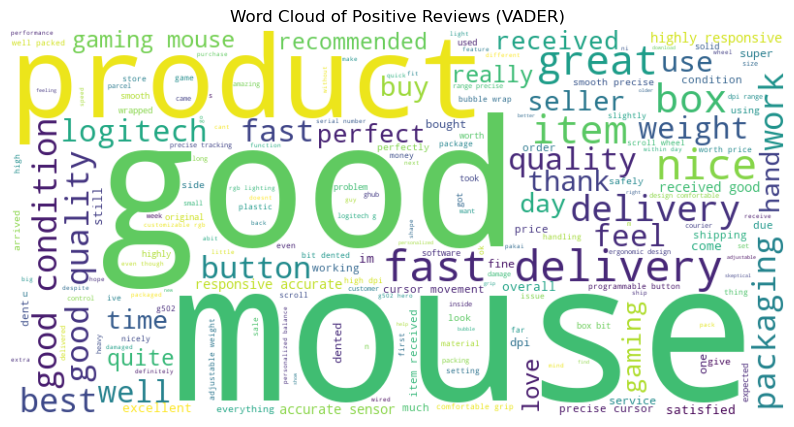

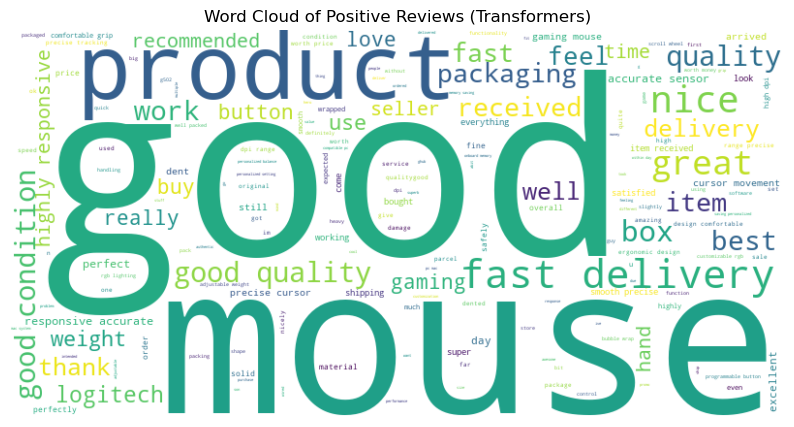

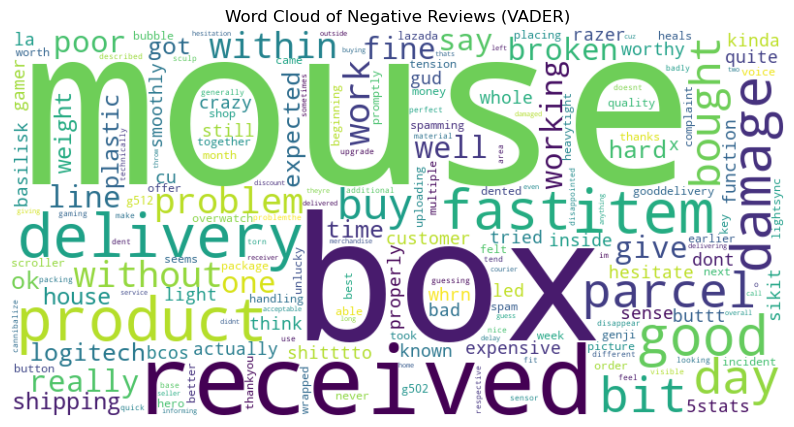

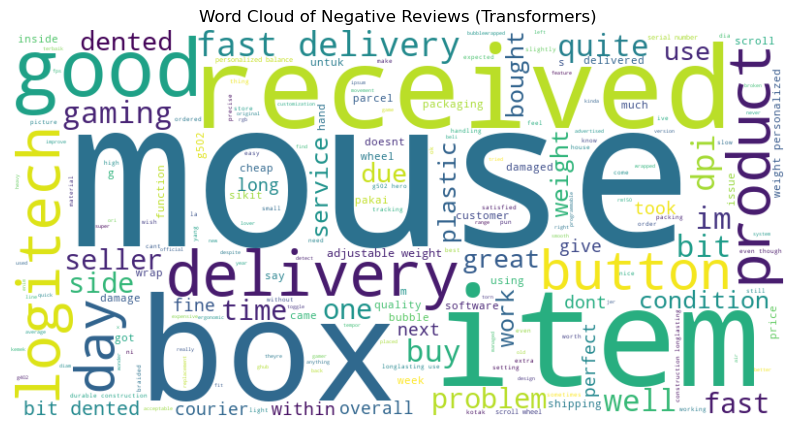

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(reviews, title):
    text = ' '.join(reviews)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for positive and negative reviews
plot_wordcloud(positive_reviews_vader.tolist(), 'Word Cloud of Positive Reviews (VADER)')
plot_wordcloud(positive_reviews_transformers.tolist(), 'Word Cloud of Positive Reviews (Transformers)')
plot_wordcloud(negative_reviews_vader.tolist(), 'Word Cloud of Negative Reviews (VADER)')
plot_wordcloud(negative_reviews_transformers.tolist(), 'Word Cloud of Negative Reviews (Transformers)')

### Conclusion
- By conducting a deeper analysis of positive and negative reviews, we can extract specific themes and actionable insights. Fine-tuning the sentiment analysis models based on the dataset characteristics helps improve their accuracy and reliability.

### Actionable Recommendations:
- Offer actionable recommendations based on the analysis, such as addressing common customer complaints or highlighting well-received features.